# **Projet Python 2A**

**Arnaud BARRAT** • **Lucas CUMUNEL** • **Aloys GALLO**



Introduction

## **Installation des modules**

Les modules Python nécessaires au bon fonctionnement du programme ainsi que les versions utilisées sont spécifiés dans le fichier `requirements.txt`.  
La commande qui suit sert à importer le modèle de NLP français de la bibliothèque `spaCy`.  

In [9]:
!pip install -r requirements.txt
!spacy download "fr_core_news_sm"

  Cloning https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to /tmp/pip-req-build-7a68pjzb
  Running command git clone --filter=blob:none --quiet https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git /tmp/pip-req-build-7a68pjzb
  Resolved https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to commit bc0ebd0135a6cc78f48ddf184069b4c0b9c017d8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 76.6 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


## **Importation des modules**

In [10]:
import requests
import bs4
import re
import pandas as pd
from rapidfuzz import fuzz
import time
from urllib.parse import quote
from langdetect import detect
from fuzzywuzzy import fuzz 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from scipy.stats import kstest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
import spacy 
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import pandas as pd
from collections import Counter

# 1. Extraction des données

## 1.1. Trouver les livres français disponibles sur [Gutenberg](gutenberg.org)

### **Importation des bibliothèques**

Tout d'abord, quelques remarques sur les bibliothèques nécessaires pour récupérer et manipuler les données :

- **requests** : Permet d'envoyer des requêtes HTTP aux sites web pour récupérer des données.
- **bs4 (BeautifulSoup)** : Permet d'analyser et d'extraire des données à partir de documents HTML récupérés sur internet.
- **re** : Fournit des fonctionnalités pour rechercher des expressions régulières (regex) dans du texte.
- **pandas** : Utilisé pour la manipulation et l'analyse de données sous forme de DataFrames.
- **rapidfuzz** : Fournit des outils efficaces pour comparer des chaînes de caractères et calculer leur similarité.

### **Récupération des informations sur les livres**

On cherche tout d'abord à confectionner une table avec les informations sur le livre et le numéro d'index auquel il correspond. Cette base sera ensuite donnée à l'API pour qu'elle donne un ou plusieurs thème à chaque texte. 

La cellule suivante permet de récupérer le texte de la page **"gutindex.all"**, qui associe chaque ouvrage à un numéro d'index.

In [11]:
# URL du fichier d'index des textes
url_liste_textes = "https://www.gutenberg.org/dirs/GUTINDEX.ALL.iso-8859-1.txt"

# Téléchargement du fichier d'index
request_liste_textes = requests.get(url_liste_textes).content
page = bs4.BeautifulSoup(request_liste_textes, "lxml")
body = page.find("body")
index_texte = body.get_text()

### **Extraction du texte et création de la table avec les informations sur les livres**

Toujours dans l'optique de créer une table avec les informations sur le texte dans une colonne et l'index dans l'autre, on ne souhaite garder que le texte correspondant aux informations et à l'index. 

On utilise pour ce faire les balises de début et de fin de l'index puis on supprime les quelques lignes inutiles qui donnent des informations sur le contenu de l'index après avoir converti le texte en une liste de lignes pour faciliter le traitement.

In [12]:
# Chercher les indices des marqueurs "<===LISTINGS===>" et "<==End of GUTINDEX.ALL==>"
start_marker = "<===LISTINGS===>"
end_marker = "<==End of GUTINDEX.ALL==>"
start_index = index_texte.find(start_marker)
end_index = index_texte.find(end_marker)

# Extraire le texte entre les marqueurs
texte_extrait = index_texte[start_index + len(start_marker):end_index].strip()
texte_extrait_lignes = texte_extrait.splitlines()

# Filtrer les lignes pertinentes
texte_extrait_lignes_trie = texte_extrait_lignes[10:len(texte_extrait_lignes)-1]
texte_complet = '\n'.join(texte_extrait_lignes_trie)

### **Séparation du texte en deux parties : Description et Index**

Il nous faut donc maintenant séparer le texte en deux parties, l'une contenant les informations sur l'oeuvre (titre, auteur, date, langue de l'oeuvre...) et l'autre le numéro d'index.
La cellule ci-dessous, après avoir divisé le texte en oeuvres, créé une liste d'oeuvre avec description (contenant les informations sur l'oeuvre) et index séparés. La première utilisation du regex dans la boucle permet d'extraire l'index tandis que la deuxième permet de retirer l'index et les espaces superflus pour ne garder que le texte pour la colonne "Description". On convertit enfin la liste en DataFrame pour la manipuler plus efficacement et on ne garde que les textes en français.

In [13]:
# Diviser le texte en oeuvres
oeuvres = re.split(r'(?=\n{2,})', texte_complet.strip())

# Extraire les descriptions et indices
data = []
for oeuvre in oeuvres:
    # Trouver l'index dans l'oeuvre
    match_index = re.search(r'(?<=\s\s)([\d]+?[A-Z]?)(?=\n)', oeuvre)
    index = match_index.group(1) if match_index else None

    # Nettoyer le texte de l'oeuvre
    description = re.sub(r'(?<=\s\s)([\d]+?[A-Z]?)(?=\n)', '', oeuvre).strip()

    # Ajouter les données
    data.append({"Description": description, "Index": index})

# Convertir les données en DataFrame
df_livres = pd.DataFrame(data)
df_livres_fr = df_livres[df_livres["Description"].str.contains(r"\[Language: French\]", na=False)]


### **Filtrage des ouvrages par auteurs célèbres du XVIIe siècle au XIXe siècle**

Afin que l'API nous donne bien des thèmes pour les textes envoyés, nous avons fait le choix, après quelques essais, de nous restreindre à ceux d'auteurs célèbres. Nous avons donc réalisé une liste d'auteurs célèbres des XVIIe siècle au XXe siècle.
La cellule ci-dessous ne garde que les ouvrages dont l'auteur est dans la liste. 

In [14]:
auteurs = [
    # XVIIe siècle
    "Honoré d'Urfé", "Madeleine de Scudéry", "Paul Scarron", "Jean de La Fontaine",
    "Madame de Lafayette", "Charles Sorel", "Tristan L'Hermite", "François de Salignac de La Mothe-Fénelon",
    "Savinien de Cyrano de Bergerac",
    
    # 18e siècle
    "Montesquieu", "Voltaire", "Jean-Jacques Rousseau", "Denis Diderot", "Marivaux",
    "Abbé Prévost", "Pierre Choderlos de Laclos", "Beaumarchais", 
    
    # 19e siècle
    "Honoré de Balzac", "Victor Hugo", "Alexandre Dumas", "Gustave Flaubert", "Émile Zola",
    "Stendhal", "Alfred de Musset", "George Sand", "Jules Verne", "Alphonse Daudet",
    "Théophile Gautier", "Edmond de Goncourt",
    "Joris-Karl Huysmans", "Octave Mirbeau", 
    "Prosper Mérimée", "Eugène Sue", "Charles Nodier",
    "Gaston Leroux", "François-René de Chateaubriand", "Anatole France", "Gustave Flaubert", "Alfred Jarry",
    "Guy de Maupassant", "Romain Rolland", "Alfred Séguin", "Alfred de Vigny", "Paul de Kock"

]

# On créé une expression réuglière que signifie "ou" pour l'utiliser ensuite
auteurs_join = "|".join(map(re.escape, auteurs))
# On filtre les lignes qui contiennent au moins un des auteurs
df_livres_fr_filtré = df_livres_fr[df_livres_fr["Description"].str.contains(auteurs_join, na=False)]
df_livres_fr_filtré.to_csv("livres_fr_triés.csv", index=False, encoding="utf-8")


## 1.2. Trouver les thèmes des livres disponibles sur Gutenberg

La deuxième étape de l'extraction des données consiste à trouver les thèmes des livres dont on sait qu'on dispose des textes dans Gutenberg. Cependant, comme Gutenberg ne fournit pas cette information, nous avons utilisé l'API [OpenLibrary](https://openlibrary.org/), qui est l'une des rares API regroupant les thèmes des livres. 

### **Sélection des auteurs**
Pour optimiser l'extraction, nous avons défini une liste d'auteurs à partir des pages Wikipedia recensant les romanciers français, en particulier ceux mentionnés dans la [catégorie des romanciers français par siècle](https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Romancier_fran%C3%A7ais_par_si%C3%A8cle). Nous avons croisé cette liste avec nos connaissances en prépa B/L pour garder uniquement les auteurs dits "classiques". Cette approche présente trois avantages :
1. **Maximiser les chances de trouver les thèmes des livres** : Les auteurs classiques ont écrit des ouvrages qui sont souvent cités et reconnus, augmentant ainsi les probabilités d’obtenir des informations sur leurs thèmes.
2. **Réduire la taille de la base de données** : En limitant la sélection aux auteurs classiques, nous évitons une requête trop large qui pourrait être difficile à traiter en termes de temps et qui aurait un impact environnemental plus fort.
3. **Faciliter l'application du projet** : En se concentrant sur des auteurs classiques, les livres sont non seulement largement accessibles, mais également facilement retrouvables dans la vie réelle pour des applications pratiques.

Toutes les étapes détaillées du processus sont expliquées dans le notebook [Get_themes.ipynb](#........................#).

### **Nettoyage des données brutes**
Nous partons de la liste des livres (fichier `nom_fichier_csv`) pour lesquels nous savons que les textes complets sont disponibles. Après avoir récupéré ces données brutes, nous effectuons un nettoyage pour obtenir un dataframe regroupant les noms des auteurs et les titres des livres. Voici quelques étapes du nettoyage :
1. **Suppression des numéros de tomes apparaissant dans les titres ;**
2. **Suppression des livres en doublon ;** 
3. **Suppression des caractères indésirables (accents mal encodés, symboles inutiles), que nous supprimons pour standardiser les titres.**

### **Requête à l'API OpenLibrary**
Une fois les données nettoyées, nous interrogeons l'API **OpenLibrary** pour obtenir les thèmes associés à chaque livre. 

### **Raisons du choix de l'API OpenLibrary**
L'API OpenLibrary a été choisie car elle est gratuite, facile d'accès, et ne nécessite pas de clé d'API. De plus, elle contient des informations sur les thèmes des livres, ce qui est essentiel pour l'analyse de nos données.

### **Problème de langue des thèmes**
L'API OpenLibrary renvoie les thèmes dans différentes langues, mais jamais en français. C’est pourquoi nous avons utilisé l'API **Lingva** (https://lingva.ml/) pour traduire ces thèmes en français.

### **Raisons du choix de l'API Lingva**
L'API **Lingva** a été choisie car elle est gratuite, ne nécessite pas de clé API et permet de traduire les thèmes rapidement. Cette API nous a permis de résoudre le problème de la langue des thèmes obtenus, en les traduisant automatiquement en français.

### **Mapping des thèmes**
Une fois les thèmes traduits, nous avons réalisé un **mapping manuel** pour nettoyer les données :
- **Suppression des thèmes non pertinents** : Certains thèmes comme "Langue française" ou "Littérature classique" étaient inutiles pour l'analyse ;
- **Regroupement des thèmes similaires pour créer des catégories plus générales.**

### **Réduction de la taille des données**
L'un des principaux défis rencontrés dans ce projet était la taille des données. En effet, nous avons commencé avec un total de 476 livres, mais il était nécessaire de réduire cette quantité pour faciliter les analyses suivantes. Le nettoyage des données a permis d'atteindre un total de 276 livres, mais ce nombre de livre demeurait trop important compte tenu de la puissance de calcul dont nous disposons.

Nous avons donc :
1. Examiné la **fréquence d'apparition des auteurs**  
Nous avons limité le nombre de livres par auteur à deux pour éviter d'avoir une base de données trop biaisée.
2. Puis obtenu une base de données finale de **96 livres**.

### **Difficultés rencontrées**
Au cours de ces étapes, plusieurs difficultés ont été rencontrées :
1. **Trouver des API pertinentes et gratuites** : trouver des API qui fournissaient les informations dont on avait besoin a été une tâche complexe.
2. **Traductions incomplètes** : L'API ne parvenait pas toujours à traduire l'ensemble des thèmes, même en insérant des pauses via `time.sleep()` avec des durées de plus en plus longues ou en mettant uniquement en langue source 'en' pour spécifier que tous les textes sont initialement en anglais.

 >**Remarque** : Étant donné que la requête de deux API prend chacune plus de 30 minutes, soit un total d'environ une heure, on importe uniquement la base de données après le nettoyage pour voir le résultat.

In [15]:
df_books = pd.read_csv('Data/final_list.csv')
df_books

,Author,Title,Year,Themes,Author_Cleaned
0,Alexandre Dumas ...,Pauline,1830,Décadence,Alexandre Dumas
1,Alexandre Dumas,Les trois mousquetaires,1830,Décadence,Alexandre Dumas
2,Alexandre Dumas ...,Gabriel Lambert,1830,Décadence,Alexandre Dumas
3,Alexandre Dumas ...,Le comte de Moret,1830,Décadence,Alexandre Dumas
4,Alexandre Dumas ...,La tulipe noire,1830,Décadence,Alexandre Dumas
...,...,...,...,...,...
83,Émile Zola ...,La curée,1885,"Décadence, Société et politique",Émile Zola
84,Émile Zola ...,Le rêve,1885,"Décadence, Société et politique",Émile Zola
85,Émile Zola,Au bonheur des dames,1885,"Décadence, Société et politique",Émile Zola
86,Émile Zola ...,Contes à Ninon,1885,"Décadence, Société et politique",Émile Zola


## 1.3. Récupération des livres dont on dispose des thèmes 

### **Correspondance des œuvres enrichies avec la base contenant les index**

Il faut maintenant faire correspondre les oeuvres de la base donnée par l'API, c'est-à-dire les oeuvres enrichies des thèmes, avec celles de la base qui contiennent leurs index de manière à pouvoir aisément récupérer les textes.

La cellule ci-dessous commence par conserver la colonne "Description" pour la mettre dans la nouvelle base car elle sera utile par la suite. Ensuite, on parcourt en parallèle le titre et l'auteur (pour ne pas confondre des oeuvres éponymes).  
On nettoie les données puis on définit différents manières de faire correspondre le titre à une partie de la description. En effet, sans cela, on perd de nombreux textes en raison de caractères spéciaux ou de sous-titres présents ou non. On définit donc un match comme une situation où un des trois modes de correspondance du titre et de la description est validé et où l'auteur est identique dans les deux bases. On forme une nouvelle base formée des informations sur les textes, de leur thème  et de leur index.  
On supprime enfin les lignes sans index puisqu'elles ne permettront pas de récupérer de  texte. 

In [16]:
# Charger la base CSV avec les livres pour ajouter l'index
books2 = r"Data/final_list.csv"  # Nom du fichier d'entrée
base_csv = pd.read_csv(books2)

# Conserver la colonne 'Description' dans la base initiale
base_csv['Description'] = ""
indices = []

# Parcourir les titres et auteurs en parallèle
for title, author in zip(base_csv['Title'], base_csv['Author']):
    # Nettoyage des données : normalisation
    df_livres_fr_filtré['Description_clean'] = df_livres_fr_filtré['Description'].str.strip().str.lower()
    title_clean = title.strip().lower()
    author_clean = author.strip().lower()

    # Correspondances exactes et approximatives
    df_livres_fr_filtré['Exact_Match'] = df_livres_fr_filtré['Description_clean'].str.match(rf"^{re.escape(title_clean)}(\s|[.,;!?]|$)", na=False)
    title_words = title_clean.split()
    df_livres_fr_filtré['Description_start'] = df_livres_fr_filtré['Description_clean'].str.split().str[:len(title_words)].str.join(' ')
    df_livres_fr_filtré['Starts_With_Title'] = df_livres_fr_filtré['Description_start'] == title_clean
    df_livres_fr_filtré['Similarity'] = df_livres_fr_filtré['Description_clean'].apply(lambda x: fuzz.ratio(title_clean, x[:len(title_clean)]))
    similarity_threshold = 90
    df_livres_fr_filtré['Approx_Match'] = df_livres_fr_filtré['Similarity'] > similarity_threshold
    df_livres_fr_filtré['Author_Present'] = df_livres_fr_filtré['Description_clean'].str.contains(author_clean, na=False)

    # Fusionner les critères
    df_livres_fr_filtré['Final_Match'] = (df_livres_fr_filtré['Exact_Match'] | df_livres_fr_filtré['Starts_With_Title'] | df_livres_fr_filtré['Approx_Match']) & df_livres_fr_filtré['Author_Present']
    match = df_livres_fr_filtré[df_livres_fr_filtré['Final_Match']]

    if not match.empty:
        # Ajouter l'index et la description correspondants
        indices.append(match.iloc[0]['Index'])
        base_csv.loc[base_csv['Title'] == title, 'Description'] = match.iloc[0]['Description']
    else:
        indices.append(None)

# Ajouter les indices trouvés à la base
base_csv['Index'] = indices

# Supprimer les lignes sans index trouvé
base_csv_index = base_csv.dropna(subset=['Index'])




/tmp/ipykernel_8301/378500651.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_livres_fr_filtré['Description_clean'] = df_livres_fr_filtré['Description'].str.strip().str.lower()
/tmp/ipykernel_8301/378500651.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_livres_fr_filtré['Exact_Match'] = df_livres_fr_filtré['Description_clean'].str.match(rf"^{re.escape(title_clean)}(\s|[.,;!?]|$)", na=False)
/tmp/ipykernel_8301/378500651.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy o

## 1.4. Création de la base de données finale avec les textes, thèmes et index

On peut enfin réaliser la base de données qui nous intéresse. Elle contient les informations sur les oeuvres, leur thème et leur texte.

Voici les étapes clés pour générer la base de données finale :

1. **Téléchargement des textes**  
On itère sur le titre et l'index pour télécharger le texte du livre (l'URL est standardisée et permet donc cette opération)

2. **Nettoyage des textes**  
On vérifie à chaque fois le succès du téléchargement pour éviter les erreurs. On se sert des marqueurs présents dans le texte pour enlever ce qui est superflu.

3. **Filtrage des textes en français**  
Nous excluons les textes qui ne sont pas en français, car nos modèles ne sont configurés que pour traiter des textes dans cette langue. Nous vérifions la langue à l'aide d'outils de détection de langue.

4. **Filtrage des textes valides**  
On supprime les textes qui ne sont pas en français (nos modèles ne traitent que les textes en français), les lignes pour lesquelles il n'y a pas de texte et les lignes pour lesquelles le type n'est pas le bon (des fichiers audios étaient contenus dans la base). 

5. **Enregistrement des données**  
On enregistre enfin la base au format csv pour pouvoir nous en servir plus aisément. 

In [17]:
# Charger la base nettoyée pour ajouter les textes
base_csv_index['Texte'] = ""

# Télécharger les textes des livres
for livre, index in base_csv_index[['Title', 'Index']].itertuples(index=False):
    url = f"https://www.gutenberg.org/cache/epub/{index}/pg{index}-images.html"
    response = requests.get(url)

    if response.status_code == 200:
        soup = bs4.BeautifulSoup(response.text, 'html.parser')
        page_text = soup.get_text()

        start_marker = f"*** START OF THE PROJECT GUTENBERG EBOOK "
        end_marker = f"*** END OF THE PROJECT GUTENBERG EBOOK"
        start_index = page_text.find(start_marker)
        end_index = page_text.find(end_marker)

        if start_index != -1 and end_index != -1:
            texte_extrait = page_text[start_index + len(start_marker):end_index].strip()
            base_csv_index.loc[base_csv_index['Title'] == livre, 'Texte'] = texte_extrait
        else:
            print(f"Marqueurs non trouvés pour {livre} (Index {index}).")
    else:
        print(f"Erreur lors du téléchargement de la page pour {livre} (Index {index}).")

base_csv_index = base_csv_index[base_csv_index["Description"].str.contains(r"\[Language: French\]", na=False)]
base_csv_index = base_csv_index.dropna(subset=['Texte'])
base_csv_index = base_csv_index[~base_csv_index['Description'].str.contains('Audio', na=False)]

# Sauvegarder la base finale
base_csv_index.to_csv("Data/base_csv_final.csv", index=False)
print(base_csv_index.head())
print(base_csv_index.shape[0])


/tmp/ipykernel_8301/4051151753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_csv_index['Texte'] = ""


Erreur lors du téléchargement de la page pour Audio (Index 20971).
                                              Author                    Title  \
0  Alexandre Dumas                               ...                  Pauline   
1                   Alexandre Dumas                   Les trois mousquetaires   
2  Alexandre Dumas                               ...          Gabriel Lambert   
3  Alexandre Dumas                               ...        Le comte de Moret   
4  Alexandre Dumas                               ...          La tulipe noire   

   Year     Themes   Author_Cleaned  \
0  1830  Décadence  Alexandre Dumas   
1  1830  Décadence  Alexandre Dumas   
2  1830  Décadence  Alexandre Dumas   
3  1830  Décadence  Alexandre Dumas   
4  1830  Décadence  Alexandre Dumas   

                                         Description  Index  \
0  Pauline, by Alexandre Dumas                   ...  71510   
1  Les trois mousquetaires, Vol. 2 of 2, by Alexa...  58211   
2  Gabriel Lambert, by

# 2. Nettoyage des données


Cette section a pour but de convertir les textes bruts comme `"Bonjour, ça va !"` en une liste de tokens `["Bonjour", "ça", "va", "!"]` et d'en retirer les termes apportant peu de sens au texte (ponctuation et stop words notamment).

Ensuite, nous  convertissons les tokens en lemmes, c'est-à-dire que nous associons à chaque mot sa racine, la forme la plus brute de sa signification. Par exemple, les verbes sont tous ramenés à l'infinitif, les adjectifs au singulier masculin.

### **Imports des bibliothèques**

Cette partie utilise :
1. `spaCy`, un package de traitement des données textuelles et de lemmatisation, le plus au point pour la langue française.
2. `french_lefff_lemmatizer.french_lefff_lemmatizer`, un lemmatiseur Lefff*.
3. `pandas` pour le traitement des dataframes  


>*Remarque : Le Lexique des formes fléchies du français est un lexique morphologique et syntaxique qui associe à la fois des propriétés morphologiques à un mot (comme sa nature) et syntaxiques (sa place dans la phrase). Ce type de lexique permet plus de précision pour la lemmatisation.

### **Initialisation**

Récupération des données textuelles obtenues sur le site [Gutenberg](gutenberg.org) et initialisation du modèle de traitement de texte `"fr_core_news_sm"` pour la tokenisation. Nous en profitons pour récupérer la liste de stopwords associée au modèle (mots portant peu de sens comme les conjonctions de coordination).  

In [18]:
#Data collecting
d_texts=pd.read_csv("Data/base_csv_final.csv")
#List of the texts
l_texts=list(d_texts["Texte"])
#Fonction rendant le texte compréhensible (séparation des mots en token, connaissance des lemmes...) par le programme
nlp = spacy.load("fr_core_news_sm")
#List de stop words (mots porteur de peu de sens comme les determinants)
stop_words_fr = nlp.Defaults.stop_words

### **Lemmatisation**

`spaCy` possède un lemmatiseur intégré (récupérable via `token.lemma_`) mais qui n'utilise pas le Lefff et donc, dans l'ensemble, moins performant. Le lemmatiseur Lefff que nous utilisons est celui de [Claude Coulombe](https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer) qui a servi de base pour le lemmatiseur `spaCy-lefff`. Nous utilisons le premier parce qu'il se trouvait plus simple à implémenter dans notre programme tout en étant suffisamment performant.

Voici deux fonctions servant à lemmatiser : `f_lemmatizer` pour le lemmatiseur de `spaCy` et `f_lemmatizer_CC` pour le lemmatiseur Lefff de Claude Coulombe. Notons que la première utilise le modèle pour extraire les lemmes là où la seconde n'a besoin que de la liste des tokens (ce qui est logique dans la mesure où elle utilise le Lefff et non le modèle français de `spaCy`).

In [19]:
#Texte brut (txt) convertit en une liste de lemmes

#spaCy : tokenisation et lemmatisation simultanée car les opérations proviennent du même package, spaCy.
def f_lemmatizer (txt) :

    #t.lemma_ correspond au lemme du token "t" et t.tag_ à son type (adjectif, nom commun...)
    txt_lemma =[(t.lemma_,t.tag_) for t in nlp(txt)]
    #Retrait des stopwords
    txt_lemma = [t for t in txt_lemma if t[0] not in stop_words_fr]
    
    return txt_lemma 

#Claude Coulombe : tokenisation et lemmatisation séparées car les opérations proviennent de deux packages (spaCy et lemmatiseur Lefff).
def f_lemmatizer_CC (txt) :

    #Conversion sous formes de token et premier tri des stopwords
    txt_token =[t.text for t in nlp(txt) if t.text not in stop_words_fr]

    #Initialisation du lemmatiseur Lefff
    lemmatizer = FrenchLefffLemmatizer()
    #Récupération des lemmes et des types (contenus dans lemmatizer.lemmatize(t,'all')) en laissant les tuples vides
    txt_lemma_CC=[lemmatizer.lemmatize(t,'all')[0] for t in txt_token if len(lemmatizer.lemmatize(t,'all'))!=0]#cette fonction prend les textes et non la version fr_core_news_sm
    #Retrait des stopwords restants dans les nouveaux lemmes
    txt_lemma_CC=[t for t in txt_lemma_CC if t[0] not in stop_words_fr]
    
    return txt_lemma_CC #meilleur mais perte des chiffres

### Précisions sur le lemmatiseur Lefff :
`lemmatizer.lemmatize(t,'all')` renvoie une liste de tuples avec les différentes significations (lemme et type) possibles pour chaque mot. Nous choisissons toujours le premier, presque toujours le plus pertinent. Voici un exemple : 

In [20]:
#Même principe que pour f_lemmatizer_CC
sample="Bonjour, ça va !"
sample_token =[t.text for t in nlp(sample)]
lemmatizer = FrenchLefffLemmatizer()
sample_lemma=[lemmatizer.lemmatize(t,'all') for t in sample_token if len(lemmatizer.lemmatize(t,'all'))!=0]


print("Lemmes et types possibles pour 'Bonjour' :\n",sample_lemma[0])

print("Lemmes et types possibles pour 'ça' :\n",sample_lemma[2])

Lemmes et types possibles pour 'Bonjour' :
 [('bonjour', 'nc'), ('bonjour', 'pres'), ('Bonjour', 'np')]
Lemmes et types possibles pour 'ça' :
 [('çaimp', 'caimp'), ('cela', 'pro')]


Par la suite, nous n'utiliserons que le lemmatiseur Lefff de Claude Coulombe pour des raisons de performance (reconnait mieux les verbes et les noms propres en général) et de praticité (les deux lemmatiseurs n'ont pas la même nomenclature pour les types de mots par exemple). Vous remarquerez cependant que le lemmatiseur de spaCy est plus rapide au travers de cet exemple : 

In [21]:
sample= "C'était à Mégara, faubourg de Carthage, dans les jardins d'Hamilcar. Les soldats qu'il avait commandés en Sicile se donnaient un grand festin pour célébrer le jour anniversaire de la bataille d'Eryx, et comme le maître était absent et qu'ils se trouvaient nombreux, ils mangeaient et ils buvaient en pleine liberté."

print(" ".join([l[0] for l in f_lemmatizer(sample)]))
print(" ".join([l[0] for l in f_lemmatizer_CC(sample)]))

Mégara , faubourg Carthage , jardin Hamilcar . soldat commander Sicile donner grand festin célébrer jour anniversaire bataille Eryx , maître abser trouver , manger boire pleine liberté .
Mégara , faubourg Carthage , jardin Hamilcar . soldat commandé Sicile donner grand festin célébrer jour anniversaire bataille Eryx , maître absent trouver , manger boire plein liberté .


### **Limites**

Malgré l'utilisation d'un lemmatiseur Lefff, les résultats restent approximatifs montrant toute la difficulté de résumer le sens d'une phrase, qui plus est en français. Et ce d'autant plus que la lemmatisation du français est moins développée que celle de l'anglais par exemple (ce qui explique que nous soyons passés par une version encore non aboutie de Lemmatiseur Lefff).  
Cependant, notre ambition étant de classer des textes entiers, l'approche par la lemmatisation et par la suite les matrices TF IDF semble la plus réaliste.

## 2.2. Export des textes lemmatisés

Comme nous appliquons la fonction `f_lemmatizer_CC` sur une centaine de textes très massifs, nous stockons les textes lemmatisés dans un fichier `.parquet`.  
**Attention** : ce code peut être long à s'exécuter, les cellules suivantes utiliseront les fichiers `.parquet` créés à partir de ce code.

In [22]:
#Augmentation de la taille maximale que nlp() peut lire
nlp.max_length=100000000
#Liste des textes lemmatisés
l_txt_lemmas=[]

for idx,txt in enumerate(l_texts) : 
    
    #Ponctuation et noms propres exclus
    txt_lemmas=([t[0] for t in f_lemmatizer(txt) if t[1] not in ["epsilon","ponctw","poncts","parento","parentf","np"]])
    #Conversion en dataframe
    df=pd.DataFrame({"Lemmes": txt_lemmas})
    #Ajout d'un indice pour différencier les textes
    l_txt_lemmas.append(df.assign(Id=idx))

KeyboardInterrupt: 

In [23]:
#Concaténation des dataframes
file=pd.concat(l_txt_lemmas, ignore_index=True)
#Export au format parquet
file.to_parquet('Data/lemmes.parquet', engine='pyarrow')

## 2.3. Export des types et des fréquences  

Les lemmatiseurs nous donnent accès non seulement à la fréquence mais aussi aux types des mots, que nous avons donc recensés pour pouvoir avoir un regard plus fin sur nos données.

In [24]:
#A partir des tuples (lemme,type), création d'un dataframe avec type et fréquence des lemmes
def info_table (txt_type, id) :    
    #Pour les types   
    df_type=pd.DataFrame(data=txt_type, columns=['Word','Type'])

    #Comptage des occurences de chaque lemme
    txt_count=Counter([t[0] for t in txt_type])
    #Pour les fréquences
    df_count=pd.DataFrame.from_dict(data=txt_count,orient='index',columns=["Freq"])
    #On renomme l'index pour préparer la fusion avec df_type
    df_count=df_count.reset_index()
    df_count=df_count.rename(columns={"index":"Word"})

    #Dataframe final
    df_final=df_type.merge(df_count,on='Word')
    #Supression des doublons
    df_final=df_final.drop_duplicates(subset=['Word'])

    return df_final.assign(Id=id) #ajout de l'id pour différencier les textes

### **Récupération des types et fréquences**

Comme pour la partie lemmatisation, on stoque ces informations dans un fichier parquet pour gagner du temps.  
**Attention** : ce code peut être long à s'exécuter, les suivantes suivantes utiliseront les fichiers `.parquet` créés à partir de ce code.

In [25]:
#Liste des dataframes type et fréquence
l_txt_info=[]

for idx,txt in enumerate(l_texts) : 

    #Couples (lemme,type)
    txt_type=(f_lemmatizer_CC(txt))

    #Dataframe type et fréquence
    df_info=info_table(txt_type, idx)
    l_txt_info.append(df_info)

KeyboardInterrupt: 

In [ ]:
#Concaténation des dataframes
file=pd.concat(l_txt_lemmas, ignore_index=True)
#Export au format parquet
file.to_parquet('Data/info.parquet', engine='pyarrow')

# 3. Statistiques descriptives

Ici nous analyserons de façon globale les données textuelles que nous avons, en l'occurrence un corpus de 87 textes lemmatisés avec pour chaque lemme sa **fréquence** et son **type** associés.

Pour ce faire nous aurons besoin de :  
1.  `numpy` et `pandas` pour les opérations sur les données 
2.  `matplotlib.pyplot` pour la création de graphiques
3.  `wordcloud` pour le nuage de points

### **Initialisation** 

Nous récupérons les **titres** des textes de `'Data/base_csv_final.csv'` et les **lemmes** (et leur fréquences et leurs types) de `'Data/info.parquet'`.

In [27]:
#Collecting data
texts=pd.read_csv('Data/base_csv_final.csv')
d_titles=texts['Title'].to_dict()
data=pd.read_parquet('Data/info.parquet', engine='pyarrow')

### **Le corpus**

Pour avoir une idée du contenu global des 87 livres du corpus, nous allons tracer un nuage des lemmes les plus utilisés. Pour ce faire, nous utilisons le package `wordcloud` qui sert à créer des nuages de points.

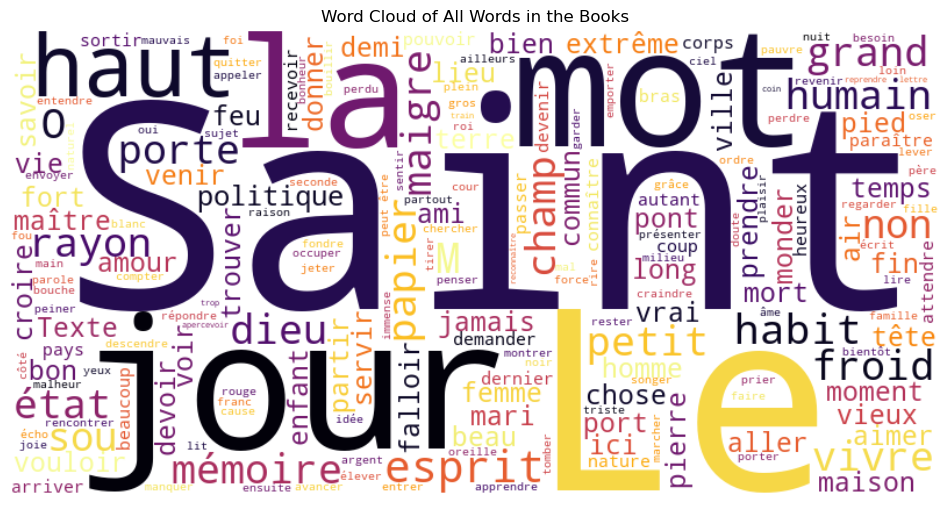

In [20]:
#Rassemble tous les mots dans data 
all_words = " ".join(data[data['Type'].isin(['nc', 'v', 'adj', 'np', 'adv'])]['Word'].astype(str))

#Création du nuage à partir des mots de data
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='inferno').generate(all_words)

#Taille graph
plt.figure(figsize=(12, 8))
#Dessin du nuage
plt.imshow(wordcloud, interpolation='bilinear')
#Retrait des axes
plt.axis('off')
#Titre
plt.title('Word Cloud of All Words in the Books')
#Affichage
plt.show()


### **Remarques**

Les mots les plus présents dans le corpus sont des mots assez généraux, ce qui est assez rassurant. Des déterminants comme "le" ou "la", des noms communs renvoyant à des choses du quotidien comme "jour" ou "habit" ou encore des verbes communs comme "aller" ou "faire". La présence du mot "saint" comme le plus récurrent est la seule données vraiment surprenante de ce nuage de point. L'absence du verbe "être" et "avoir" aurait pu l'être aussi mais elle s'explique par leur catégorisation comme auxiliaire.

## 3.1. Données sur les lemmes des livres du corpus

### **Nombre de mots**

Cette cellule sert à afficher le **nombre total de mots** dans chaque livre. Sans rentrer dans les détails :
1. Il récupère les fréquences de chaque lemmes dans la colonne `"Freq"`(en tenant compte du livre auquel ils appartiennt grâce à la colonne `"Id"`)
2. Il ne garde des titres que les 4 premiers mots pour des raisons d'affichage et trie les données dans l'ordre croissant
3. Les dernières lignes sont des commandes d'affichages propre à `matplotlib.pyplot` qui seront peu ou prou les mêmes pour chaque graphique


In [28]:
#Nombre total de mots par livre
w_total = data.groupby('Id')['Freq'].sum()

#Titre avec seulement les 4 premiers mots et nombre total de mots
d_total = {
    ' '.join(d_titles.get(book_id, book_id).split()[:3]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 3 else ''): count
    for book_id, count in w_total.items()
}

#Tri par valeurs croissantes
d_total_sorted = dict(sorted(d_total.items(), key=lambda item: item[1]))

# Positions for the x-axis
x_positions = np.arange(len(d_total_sorted)) * 2

#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(d_total_sorted))*2
#Tracé des barres
plt.bar(x_positions, list(d_total_sorted.values()), color='green', width=0.9)
#Titre et labels des axes
plt.title('Total Number of Words per Book')
plt.xlabel('Books')
plt.ylabel('Total Number of Words')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, list(d_total_sorted.keys()), rotation=90, ha='center', fontsize=10)
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()

AttributeError: 'int' object has no attribute 'split'

### **Remarque**

Nous avons ainsi une meilleure idée de la distribution des tailles des livres. *Memnon* est par exemple le plus court, Le comte de... (*Le comte de Moret*), le plus long.

# **Nombre de mots différents**

Maintenant, regardons la distribution de la diversité des lemmes. Le programme est sensiblement le même qu'au-dessus, à cela près qu'il s'intéresse aux valeurs uniques de la colonne `Word` (Lemmes) plutôt que `Freq`.

In [25]:
#Nombre de mots différents par livre
w_unique = data.groupby('Id')['Word'].nunique()

#Titre avec seulement les 4 premiers mots et nombre de mots unique
d_unique = {
    ' '.join(d_titles.get(book_id, book_id).split()[:3]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 3 else ''): count
    for book_id, count in w_unique.items()
}

#Tri par valeurs croissantes
d_unique_sorted = dict(sorted(d_unique.items(), key=lambda item: item[1]))

# Positions for the x-axis
x_positions = np.arange(len(d_unique_sorted)) * 2

#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(d_freq_sorted))*2
#Tracé des barres
plt.bar(x_positions, list(d_unique_sorted.values()), color='green', width=0.9)
#Titre et labels des axes
plt.title('Number of Unique Words per Book')
plt.xlabel('Books')
plt.ylabel('Number of Unique Words')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, list(d_unique_sorted.keys()), rotation=90, ha='center', fontsize=10)
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()


AttributeError: 'int' object has no attribute 'split'

### **Remarques**

*Le Memnon* reste le livre avec le plus petit nombres de lemmes et le bas de la distribution change peu du fait de questions de proportions. En revanche, le haut de la distribution change beaucoup. Par exemple, *Le capitaine Fracasse* a le plus grand nombre de lemmes différents et à l'inverse, malgré sa grande taille, *Le comte de Moret* se retrouve en 10ème position.

### **Coefficient de diversité**

Pour véritablement avoir une idée de la diversité de chaque livre, on construit un **coefficient de diversité**. Il s'agit tout simplement du rapport entre le nombres de lemmes différents et le nombre total de lemmes. Ainsi, plus le coefficient est proche de 1, plus le vocabulaire employé est riche. Le fonctionnement du code combine les deux approches ci-dessus.

In [29]:
#Nombre de mots total par livre et nombre de mots différent
w_total= data.groupby('Id')['Freq'].sum()  
w_unique = data.groupby('Id')['Word'].nunique() 

# Coefficient de diversité (nombre de mots différents/nombre de mots total)
diversity_ratio = (w_unique / w_total).sort_values()


#Ne retient que les 4 premiers mots de d_titles et ajoute '...' si le titre est plus long
l_books =  [' '.join(d_titles.get(book_id, book_id).split()[:4]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 4 else '') for book_id in diversity_ratio.index]


#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(diversity_ratio)) * 2
#Tracé des barres
plt.bar(x_positions, diversity_ratio, color='lightcoral', width=0.9)
#Titre et labels des axes
plt.title('Diversity Ratios (unique words/total words)')
plt.xlabel('Books')
plt.ylabel('Diversity Ratio')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, l_books, rotation=90, ha='center', fontsize=10)  # Rotate x-axis labels for better readability
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()

AttributeError: 'int' object has no attribute 'split'

### **Remarques**

On observe, sans surprise, que les plus petits livres ont une diversité bien plus grande. Par exemple, la nouvelle *Un coeur simple* est la 8ème la plus riche en termes de vocabulaire et l'énorme roman qu'est *La Chartreuse de Parme* en dernière position.   
Notons qu'*Un coeur simple* est au-dessus de *Trois contes* de 8 places, alors même que cette nouvelle fait partie des trois contes. Même si les deux autres contes peuvent influer sur la diversité du vocabulaire, cela nous conforte dans l'idée que la taille du livre est une variable très importante dans l'analyse de nos données.  
Cependant, si l'on regarde le bas de la distribution, on retrouve certains des résultats au-dessus (par exemple la place cohérente de *Le capitaine Fracasse*, ayant beaucoup de lemmes et très diversifiés, par rapport à *Le comte de Moret*).
De même, *Ruy Blas* a beau être une pièce de théâtre, son faible nombre de lemmes différents (voir au-dessus) fait que son coefficient de diversité est proche de la médiane. Ainsi, même un texte plus court peut avoir un coefficient moins élevé, laissant à penser que l'indicateur est biaisé mais tout de même pertinent.

## 3.2. Données par types

Le programme suivant compte le nombre moyen de chaque type de mots, utilisé dans chaque livre. Tout d'abord, il agrège les fréquences par type et par livre puis il en calcule la moyenne grâce à `.mean()`. Ce qui nous donne un aperçu de la distribution des types des mots.

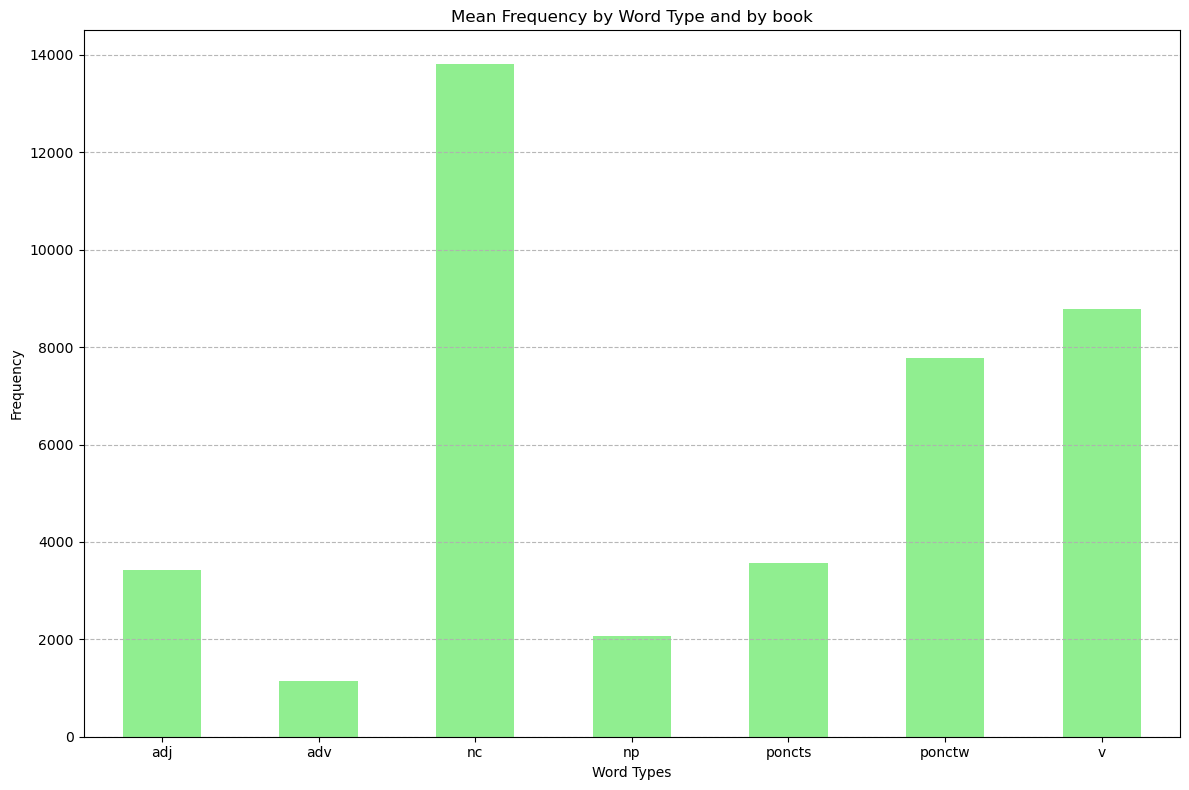

In [30]:
#Somme des fréquences par livre et type
df_stats = data.groupby(['Id', 'Type'])['Freq'].sum().reset_index()
#Récupération des moyenns par type
df_stats = df_stats.groupby('Type')['Freq'].mean()

#Liste des principeaux types de mots
l_included = ['nc', 'v', 'adj', 'np', 'adv', 'ponctw','poncts']

#Filtrage pour ne garder que les types voulus
df_filtered = df_stats[df_stats.index.isin(l_included)]

# Step 3: Plot the results
df_filtered.plot(kind='bar', figsize=(12, 8), color=['lightgreen'])

#Titre et labels des axes
plt.title('Mean Frequency by Word Type and by book')
plt.xlabel('Word Types')
plt.ylabel('Frequency')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Abscisses mises à l'horizontal
plt.xticks(rotation=0)
#Affichage
plt.tight_layout()
plt.show()

### **Remarques**

La distribution des types est très cohérentes. Les noms communs, les marques de ponctuations (`"poncts"` et `"ponctw"`) et les verbes sont omniprésents. Les adjectifs semblent légèrement rares par rapport à ce à quoi l'on pourrait s'attendre. en revanche, les adverbes sont, de façon très logique peu présents.

## 3.3. Données par thèmes

### **Nombre de livres par thèmes**

Regardons maintenant la distribution des livres par thème. Le programme fonctionne comme suit : 
1. Il réorganise la colonne `"Themes"` en dupliquant chaque ligne contenant plusieurs thèmes (pour n'avoir plus qu'un thème par ligne)
2. Il recense le nombre de livres pour chaque thème
3. Affichage de l'histogramme grâce à `matplotlib.pyplot`

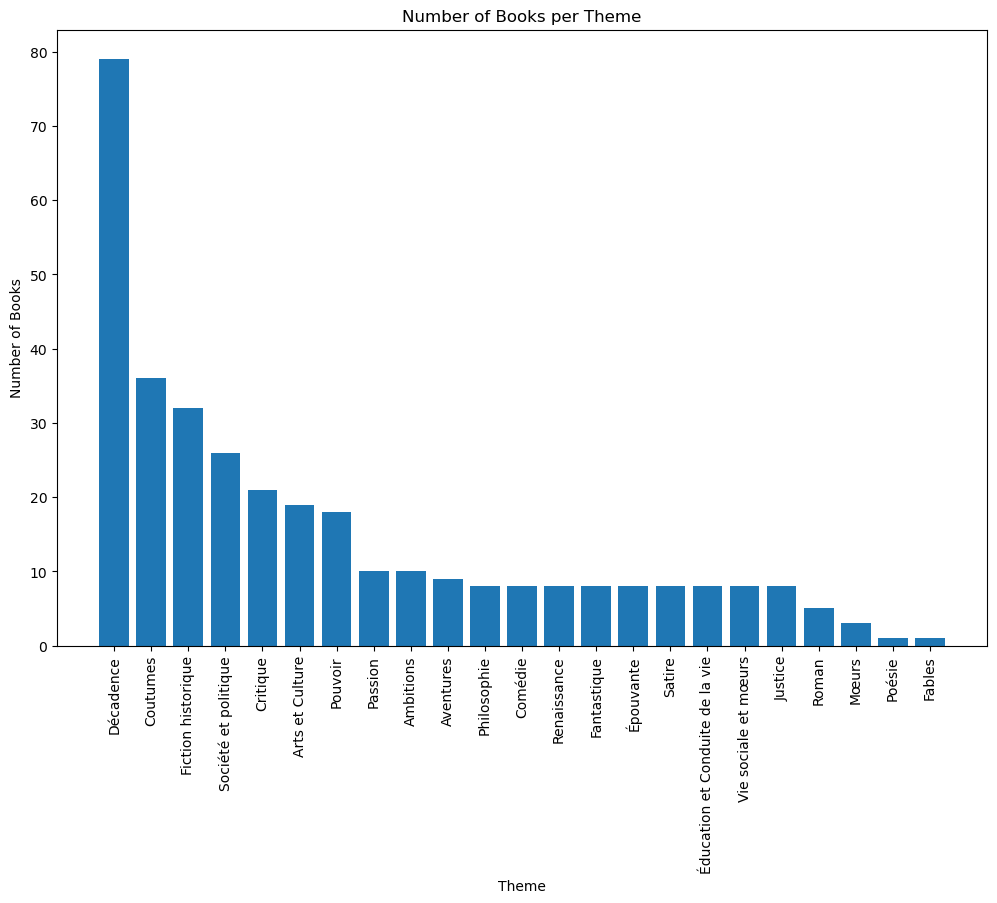

In [31]:
#Séparation des thèmes en listes si les thèmes sont sous forme d'un unique string
texts['Themes'] = texts['Themes'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

#Création de lignes spullémentaires pour qu'il n'y ait plus que un thème par ligne
texts_exploded = texts.explode("Themes")

#Nombre de livres par thème dans un dataframe
df_counts = texts_exploded['Themes'].value_counts().reset_index()
df_counts.columns = ['Theme', 'Number of Books']


#Taille graph
plt.figure(figsize=(12, 8))
#Tracé des barres
plt.bar(df_counts['Theme'], df_counts['Number of Books'])
#Titre et labels des axes
plt.xlabel('Theme')
plt.ylabel('Number of Books')
plt.title('Number of Books per Theme')
#Abscisses à l'horizontal
plt.xticks(rotation=90, fontsize=10)
#Affichage
plt.show()

### **Remarques**

Notre corpus contient des thèmes avec de nombreux représentants mais pour l'essentiel, chaque thème est présent dans moins d'une dizaine de livres. Le thème de la décadence et du roman sont fortement représentés. Si le second peut s'expliquer par son caractère général et par le fait qu'il s'agit d'un genre plus développé que la poésie par exemple, le premier est plus surprenant. Sans doute le choix de la période (XVIIIème et XIXème siècles) peut en expliquer une partie. 

### **Vocabulaire des thèmes**

Après le nombre de livres par thèmes, regardons la répartition des lemmes par thèmes. Le code ci-dessous fonctionne de la sorte : 
1. Il parcourt et recense les fréquences de chaque lemmes en fonction du thème et du livre
2. A partir de ces fréquences il retient les 20 mots les plus utilisés dans tout le corpus et les mots qui apparaissent dans plus de 3 livres différents ayant les mêmes thèmes
3. Il recense ensuite les fréquences des lemmes qui ne sont ni très utilisés, ni présents dans plusieurs livres aux mêmes thèmes
4. Il affiche le graphique de quelques thèmes


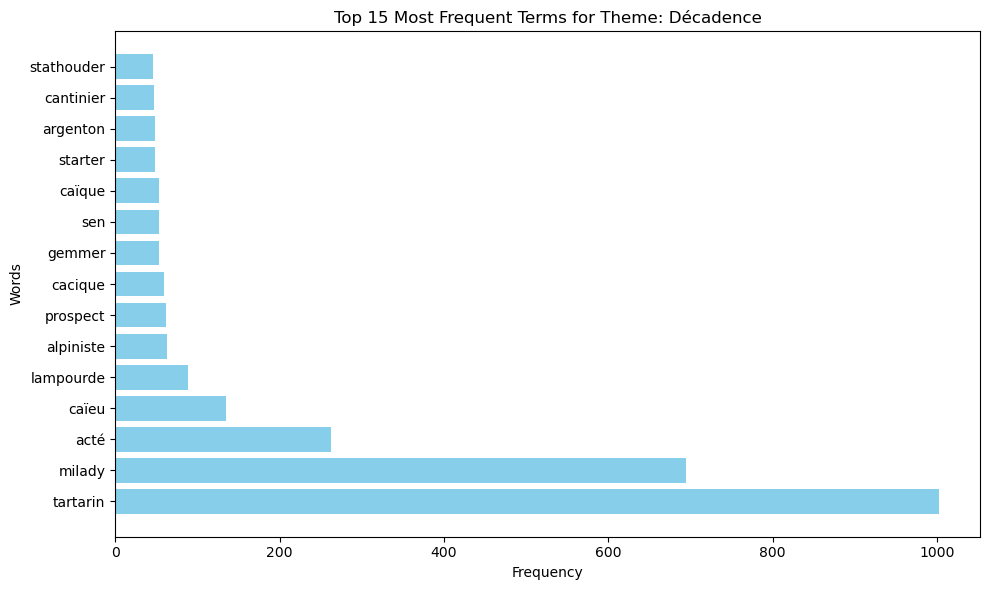

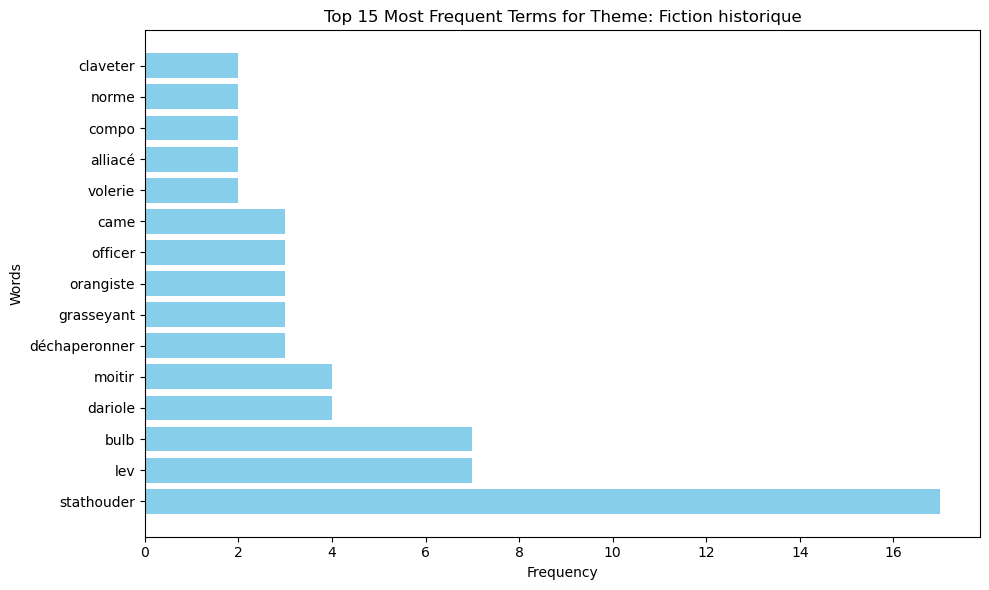

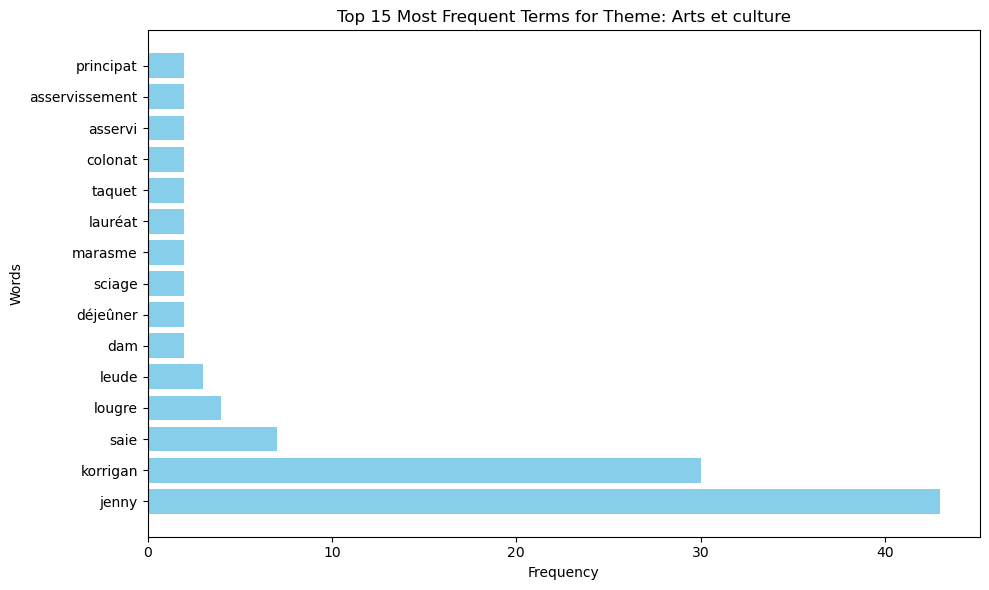

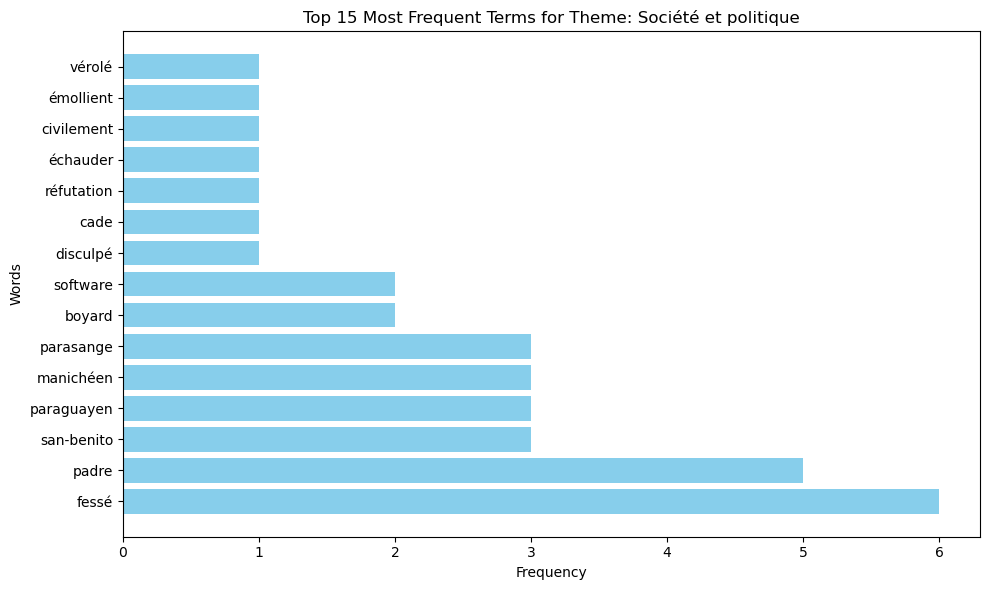

In [33]:
theme_word_freq = defaultdict(lambda: defaultdict(int))

exclude_types = ["epsilon", "ponctw", "poncts", "parento", "parentf", "np"]

total_word_freq = defaultdict(int)

word_theme_count = defaultdict(int)

#Comptage des occurences de chaque mot et de chaque mot par thème
for idx, row in texts.iterrows():
 
    book_title = row['Title']
    themes = row['Themes']
    
    book_id = idx 
    
    book_df = data[data['Id'] == book_id]
    
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for word, freq, word_type in zip(words, frequencies, types):
        if word_type not in exclude_types:
            total_word_freq[word] += freq
            
            for theme in themes:
                word_theme_count[word] += 1

#Listes des lemmes à exclure (les 20 plus présents et ceux présents dans plus de 2 thèmes)
top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}
exclude_words = {word for word, count in word_theme_count.items() if count > 3}

#Récupération des fréquences des lemmes qui ne sont pas dans les listes au-dessus
for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    
    book_id = idx  

    book_df = data[data['Id'] == book_id]
   
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for theme in themes:
        for word, freq, word_type in zip(words, frequencies, types): 
            if word_type not in exclude_types and word not in top_20_words and word not in exclude_words:  
                freq = float(freq)  
                theme_word_freq[theme.strip().lower()][word] += freq  

#Thèmes à afficher
themes_to_plot = ["Décadence","Société et politique", "Fiction historique","Arts et culture"] 

for theme, word_freqs in theme_word_freq.items():
    
    if theme in [t.lower() for t in themes_to_plot]:
        
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
        words, freqs = zip(*sorted_words)
        
        #Paramètres d'affichage
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.title(f"Top 15 Most Frequent Terms for Theme: {theme.capitalize()}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()


### **Remarques**

Comme nous avons imposé que les lemmes dans chaque thèmes ne soient pas très utilisés (pour garantir qu'ils soient plus représentatifs de chaque thèmes), certains lemmes ont peu d'occurrences. Le thème `"Fiction historique"` en particulier culmine à 7 occurrences.  
Cependant, grâce à cette sélection, les mots présents sont assez représentatifs de leur thème pour l'essentiel, du moins pour les thèmes fortement représentés. Le thème `"Société et politique"` par exemple, comprend des mots comme "antisémitisme" ou "immobilier".  
Si l'on s'intéresse maintenant au thème `"Arts et culture"`, aucun mot ne semble vraiment renvoyer à ce thème et les deux mots les plus présents en termes de fréquence le sont sans doute du fait d'un ou deux livres où ils sont répétés.
Là encore, la taille de l'échantillon importe beaucoup, même s'il ne s'agit plus de la taille des livres mais des thèmes.

## **Conclusion**

Pour conclure, les données sont dans l'ensemble plutôt cohérentes. Cependant, la forte dispersion des tailles des livres et de leur représentation dans les différents thèmes risquent de biaiser nos résultats. Même si l'on remarque que plus les livres semblent grands et pareillement plus les thèmes ont de représentants, plus les résultats semblent robustes (voir les lemmes du thème `"Société et Politique"` et les coefficients de diversité des livres les plus longs).  
Enfin, certains thèmes très représentés sont assez proches en termes de sens comme `"Décadence"`, `"Coutumes"` et `"Société et Politique"`, nous amenant à penser que les résultats de notre modèle de clustering sera sans doute peu concluant ou en tout cas, devront reposer sur d'autres thèmes.

# 4. Clustering des données : Application de la méthode VBGMM

Pour réaliser un clustering sur les livres, nous avons choisi d'appliquer la méthode **VBGMM (Variational Bayesian Gaussian Mixture Model)**.

## 4.1. Pourquoi la méthode VBGMM ?
1. **Estimation du nombre de clusters** :  
   Contrairement à une méthode classique de mélange gaussien (GMM), où le nombre de clusters doit être fixé à l'avance, VBGMM utilise une approche bayésienne variationnelle pour déterminer automatiquement le nombre optimal de clusters en fonction des données.

2. **Gestion des données complexes** :  
   La méthode est particulièrement efficace pour les ensembles de données complexes et de haute dimension, comme ceux impliquant des thèmes littéraires et des métadonnées textuelles.

3. **Réduction des biais** :  
   La pondération bayésienne permet d'éviter le sur-ajustement en pénalisant les clusters inutiles ou redondants.


### **Conditions pour utiliser la méthode VBGMM**

L'application de la méthode **VBGMM (Variational Bayesian Gaussian Mixture Model)** repose sur certaines conditions et prérequis pour garantir des résultats optimaux et une interprétation valide des clusters.

1. Données numériques dans un espace vectoriel
- Les données d'entrée doivent être représentées sous forme numérique. Nous utilisons donc une matrice Tf-IDF dense, c'est-à-dire dont la majorité des éléments sont différents de zéro.

2. Hypothèse d'une distribution gaussienne
- VBGMM suppose que chaque cluster suit une distribution gaussienne.  


3. Absence de valeurs aberrantes
- Les données ne doivent pas contenir de valeurs aberrantes importantes comme des NaN ou des infinis


In [ ]:
df = pd.read_csv("Data/base_csv_final.csv")
df

In [ ]:
#Création de la matrice Tf_Idf
def Tf_Idf (lemmas) :
    
    voc=[]
    for l in lemmas :
        
        voc.extend(l['Lemmes'].tolist()) 
    voc = list(set(voc)) 
    
    vectorizer = TfidfVectorizer(lowercase=False, vocabulary=voc, min_df=2)
    documents = [" ".join(l['Lemmes'].tolist()) for l in lemmas]
    vectorizer.fit(documents)
    vectors=vectorizer.transform(documents)

    return vectors,vectorizer
#Récupération des textes lemmatisés
t_lemmas=[v for k, v in pd.read_parquet('Data/lemmes.parquet', engine='pyarrow').groupby('Id')]
vec,vectorizer=Tf_Idf(t_lemmas)

In [ ]:
# Convertir chaque élément de la liste en tableau dense
vec_dense = [matrix.toarray() for matrix in vec]

# Combiner toutes les matrices en une seule
vec_combined = np.vstack(vec_dense)

# Vérification de la structure des données 
# Vérifier que la moyenne des variances des colonnes n'est pas nulle
print("Moyenne des variances des colonnes :", np.var(vec_combined, axis=0).mean()) 

# Vérifier s'il n'y a pas des NaN
print("Existence de Nan :", np.any(np.isnan(vec_combined)))  

# Vérifier s'il n'y a pas des infinis
print("Existence de valeurs infinis :", np.any(np.isinf(vec_combined)))  

## 4.2. Vérification des hypothèses et réduction de dimension

Les hypothèses **1** et **3** sont bien vérifiées. Il est maintenant nécessaire de vérifier si les données suivent une **distribution gaussienne**.

Pour ce faire, une **Analyse en Composantes Principales (ACP)** est réalisée. Cette méthode permet de **réduire la dimension des données** tout en préservant le maximum de variance. Elle facilite également la **projection des données** dans un espace de dimension réduite, rendant leur visualisation plus intuitive.

In [ ]:
# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(vec_combined)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title("PCA Projection of TF-IDF Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### **Observation de la répartition des données**

Les données semblent être réparties de manière **uniforme autour de l'origine**. Visuellement, cela signifie qu'elles ne présentent pas de **concentration particulière** dans certaines zones de l'espace étudié. 

Cette répartition pourrait suggérer qu'il n'y a pas de **structures sous-jacentes** ou de **tendances marquées**, comme des regroupements naturels de points, qui pourraient indiquer la présence de clusters. 

Cependant, il est important de noter que l'absence de **clusters évidents a priori** ne signifie pas nécessairement qu'il n'en existe pas.

Pour approfondir cette analyse, affichons l'**histogramme de la première et de la seconde composante principale** afin d'examiner la structure des données de manière plus détaillée.


In [ ]:
# Création des sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogramme de la première composante principale
sns.histplot(reduced_data[:, 0], kde=True, ax=axes[0])
axes[0].set_title('Histogramme de la première composante principale')

# Histogramme de la seconde composante principale
sns.histplot(reduced_data[:, 1], kde=True, ax=axes[1])
axes[1].set_title('Histogramme de la seconde composante principale')

# Affichage du graphique
plt.tight_layout()
plt.show()

### **Analyse des distributions des composantes principales**

On observe que les données sont **globalement centrées en 0**, avec des distributions qui semblent suivre des **lois normales**, sans présenter de **valeurs aberrantes** ou d'**asymétries** notables.

Cette première observation suggère que les données pourraient suivre une **distribution normale**. Cependant, pour confirmer cette hypothèse de manière plus rigoureuse, il est nécessaire de procéder à une **évaluation précise**.

Pour ce faire, nous utiliserons les **QQ plots** (quantile-quantile plots), qui permettent de comparer les **quantiles des données** avec ceux d'une distribution normale. Cette méthode aide à valider l'**hypothèse de normalité** des données.

In [ ]:
# Création des sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot de la première composante principale
stats.probplot(reduced_data[:, 0], dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot de la première composante principale')

# Q-Q plot de la seconde composante principale
stats.probplot(reduced_data[:, 1], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot de la seconde composante principale')

# Affichage du graphique
plt.tight_layout()
plt.show()

### **Validation de la normalité avec les QQ plots**

Hormis pour les **valeurs aux extrémités**, les points des **QQ plots** suivent de manière précise la **diagonale** correspondant à la distribution théorique de la **loi normale**. 

Cette observation indique que les **quantiles des données** s'alignent étroitement avec ceux d'une distribution normale, confirmant ainsi la normalité des données.

Ces résultats permettent d'affirmer, avec beaucoup de confiance, que la **distribution des données suit une loi normale**.


In [ ]:
# Kolmogorov-Smirnov test for normality
stat1, p1 = kstest(reduced_data[:, 0], 'norm', args=(reduced_data[:, 0].mean(), reduced_data[:, 0].std()))
stat2, p2 = kstest(reduced_data[:, 1], 'norm', args=(reduced_data[:, 1].mean(), reduced_data[:, 1].std()))
print(f'Kolmogorov-Smirnov Test for First Principal Component: Statistics={stat1}, p-value={p1}')
print(f'Kolmogorov-Smirnov Test for Second Principal Component: Statistics={stat2}, p-value={p2}')


Le **test de Kolmogorov-Smirnov** (KS) est un test statistique non paramétrique utilisé pour comparer la distribution empirique des données avec une distribution théorique donnée.

### Hypothèses du test

- **Hypothèse nulle (H₀)** : Les données suivent la distribution théorique spécifiée.  


- **Hypothèse alternative (H₁)** : Les données ne suivent pas la distribution théorique spécifiée.  

### Analyse de la p-valeur

Les **p-valeurs** sont ici très élevées. Cela signifie que nous ne rejetons pas l'hypothèse nulle et que nous pouvons conclure que les données suivent bien la distribution théorique avec une grande certitude.

### **Conclusion**

L'hypothèse 3 est ainsi vérifiée. Nous pouvons désormais appliquer la méthode **VBGMM** (Variational Bayesian Gaussian Mixture Model) pour réaliser des clusters.

In [ ]:
# Create a VBGMM model
vbgmm = BayesianGaussianMixture(n_components=6, covariance_type='full')
    
# Fit the model to the data
vbgmm.fit(reduced_data)
    
# Predict the cluster for each sample
labels = vbgmm.predict(reduced_data)
    
df['Cluster'] = labels

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.title('Clusters of Books')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


In [ ]:
# Create a VBGMM model
vbgmm = BayesianGaussianMixture(n_components=6, covariance_type='full')
    
# Fit the model to the data
vbgmm.fit(reduced_data)
    
# Predict the cluster for each sample
labels = vbgmm.predict(reduced_data)
    
df['Cluster'] = labels

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.title('Clusters of Books')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

### **Variabilité des clusters lors des exécutions répétées**

On remarque qu'en appliquant plusieurs fois le même algorithme, les **clusters** obtenus sont modifiés. Cela est probablement dû à l'**initialisation aléatoire** des paramètres du modèle, qui peut influencer les résultats finaux.

Pour garantir la **reproductibilité** de l'analyse et éviter les variations liées à cette initialisation, nous allons fixer la **graine aléatoire** (*seed*). Cela permettra d'obtenir des résultats cohérents à chaque exécution de l'algorithme.

Poursuivons donc l'analyse en fixant cette graine.


In [ ]:
np.random.seed()

# Create a VBGMM model
vbgmm = BayesianGaussianMixture(n_components=6, covariance_type='full')
    
# Fit the model to the data
vbgmm.fit(reduced_data)
    
# Predict the cluster for each sample
labels = vbgmm.predict(reduced_data)
    
df['Cluster'] = labels

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.title('Clusters of Books')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

## 4.3. Résultat de l'algorithme VBGMM

L'algorithme **VBGMM (Variational Bayesian Gaussian Mixture Model)** a permis de distinguer **trois clusters** dans les données. Ces clusters représentent des regroupements naturels, identifiés à partir des caractéristiques des points dans l'espace étudié.

Avant d'analyser ces clusters en détail pour mieux comprendre leurs spécificités et les thématiques qu'ils regroupent, étudions la qualité des clusters.

In [ ]:
# Calculer les centroïdes des clusters
def compute_centroids(X, labels):
    centroids = []
    for cluster in np.unique(labels):
        cluster_points = X[labels == cluster]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
    return np.array(centroids)

# Calcul de la distance intra-cluster (moyenne des distances aux centroïdes)
def intra_cluster_distance(X, labels, centroids):
    intra_distances = []
    for cluster in np.unique(labels):
        cluster_points = X[labels == cluster]
        centroid = centroids[cluster]
        distance = np.mean(np.linalg.norm(cluster_points - centroid, axis=1))
        intra_distances.append(distance)
    return np.mean(intra_distances)

# Calcul de la distance inter-cluster (moyenne des distances entre clusters)
def inter_cluster_distance(X, labels, centroids):
    inter_distances = []
    for i, centroid_i in enumerate(centroids):
        for j, centroid_j in enumerate(centroids):
            if i != j:
                dist = np.linalg.norm(centroid_i - centroid_j)
                inter_distances.append(dist)
    return np.mean(inter_distances)


# Calcul des centroïdes
centroids = compute_centroids(df, labels)

# Calcul de la distance intra-cluster
intra_dist = intra_cluster_distance(df, labels, centroids)

# Calcul de la distance inter-cluster
inter_dist = inter_cluster_distance(df, labels, centroids)

print(f"Distance intra-cluster : {intra_dist}")
print(f"Distance inter-cluster : {inter_dist}")


### **Évaluation de la qualité du modèle**

L'évaluation de la qualité du modèle en utilisant les distances inter et intra-clusters n'est pas possible en raison de limitations computationnelles, entraînant l'erreur suivante : **"Maximum call stack size exceeded"**. 

Pour contourner cette contrainte, nous avons décidé d'évaluer les clusters à l'aide du **score de silhouette**. 

Le **score de silhouette** mesure la cohésion et la séparation des clusters :  
- Il calcule la **différence entre la distance moyenne d'un point avec les autres points de son cluster (cohésion)** et la **distance moyenne avec les points du cluster voisin le plus proche (séparation)**.
- Un score de silhouette proche de 1 indique que les clusters sont bien définis, c'est-à-dire qu'ils ont une forte cohésion et une bonne séparation. 


In [ ]:
vbgmm = BayesianGaussianMixture(n_components=3, random_state=42)
vbgmm.fit(reduced_data)
labels = vbgmm.predict(reduced_data)

# Calcul du silhouette score
f"Silhouette Score : {silhouette_score(reduced_data, labels)}"

#### Interprétation du score de silhouette

Un score de silhouette de **0,42** indique que les clusters formés par l'algorithme sont **relativement pertinents**. Cela suggère que les points d'un même cluster sont modérément proches les uns des autres, tandis qu'ils sont bien séparés des autres clusters.

#### Limitation et alternative

Pour améliorer la prise en compte des thèmes, une autre approche aurait été d'encoder les thèmes dans une matrice **one-hot** et de la **concaténer avec la matrice TF-IDF**. Cependant, cette méthode présente un inconvénient majeur :  
- **Modification de la distribution des données** : Une telle transformation affecte la structure statistique des données, qui ne suivraient plus une loi gaussienne.  
- Cela rendrait l'algorithme **VBGMM caduc**, car celui-ci repose sur l'hypothèse de normalité des données.

#### Comparaison des thèmes des clusters

Pour répondre à la problématique et analyser les différences entre les clusters, nous comparons les thèmes associés à chaque cluster. Une représentation sous forme de **heatmap** est utilisée pour visualiser la fréquence des thèmes dans chaque cluster. Cette approche permet de mettre en lumière les caractéristiques dominantes de chaque cluster et d'explorer les relations entre thèmes et regroupements.


In [ ]:
print("Nombre de livres dans le cluster 0 : ", df['Cluster'].value_counts()[0])
print("Nombre de livres dans le cluster 1 : ", df['Cluster'].value_counts()[1])
print("Nombre de livres dans le cluster 2 : ", df['Cluster'].value_counts()[2])


df['Themes'] = df['Themes'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

df_exploded = df.explode('Themes')
theme_counts = df_exploded.groupby(['Cluster', 'Themes']).size().unstack(fill_value=0)

# Créer la heatmap pour visualiser les comptes de thèmes par cluster
plt.figure(figsize=(10, 6))
sns.heatmap(theme_counts, annot=True, cmap='Blues', fmt='d', cbar=True)

# Ajouter des titres et labels
plt.title('Nombre d\'apparitions de chaque thème par cluster', fontsize=14)
plt.xlabel('Thèmes', fontsize=12)
plt.ylabel('Clusters', fontsize=12)

# Afficher la heatmap
plt.tight_layout()
plt.show()


## 4.4. Analyse des clusters

### Cluster 0 et Cluster 2 : Similarités et différences
On remarque que les clusters 0 et 2 sont relativement similaires, principalement en raison de la forte occurrence des thèmes tels que **décadence**, **roman**, **société et politique**, **fiction historique**, **pouvoir** et **coutumes**. Ces thèmes suggèrent que les livres dans ces deux clusters partagent des préoccupations liées aux dynamiques sociales et politiques, explorant les relations humaines, les conflits de pouvoir, ainsi que les dilemmes moraux dans des contextes historiques.

**Cluster 0** se distingue par une présence supplémentaire des thèmes **passions** et **ambitions**. Cela suggère que ce cluster regroupe des romans qui ne se contentent pas de décrire des contextes sociaux ou politiques, mais qui mettent également l'accent sur les émotions humaines et les aspirations personnelles, rendant ces récits plus intenses et dramatiques. Ces livres explorent les enjeux individuels au sein de sociétés marquées par des tensions sociales et politiques, avec une forte dimension historique.

**Cluster 2**, bien qu'il partage des thèmes similaires, semble davantage mettre l'accent sur des aspects **institutionnels** et **sociaux**, tels que la **culture**, les **mœurs**, et **l'éducation**. Cela suggère que les livres du cluster 2 se concentrent peut-être plus sur les structures sociales et les valeurs culturelles que sur les dynamiques émotionnelles et les conflits personnels. Ces romans abordent probablement des questionnements sur les normes et les pratiques sociales dans un cadre historique ou social donné, sans nécessairement explorer les passions ou les ambitions des individus.

### Cluster 1 : Romans d'aventure et de voyage
Le **cluster 1** semble se différencier nettement des autres en mettant l'accent sur les **romans d'aventure** et de **voyage**, souvent caractérisés par une **dimension fantastique** ou **merveilleuse**. Les thèmes présents dans ce cluster suggèrent des récits qui, tout en étant parfois ancrés dans une certaine réalité géographique, s'éloignent dans une certaine mesure des préoccupations sociales ou politiques pour se concentrer sur des aventures extraordinaires, des explorations de nouveaux mondes ou des quêtes héroïques. Ces livres semblent inviter le lecteur à s'évader, en découvrant des univers lointains et fascinants, souvent empreints de mystère ou de fantastique.

# 5. Pistes d'amélioration

## 5.1. Pour la récupération des données

C'est clairement la partie qui nous aura pris le plus de temps, trop de temps même. L'utilisation (et la recherche) d'API peu efficaces et précises a considérablement ralenti notre récupération des données.

## 5.2. Pour la tokénisation

Nous avons envisagé d'ajouter des **2-grams** (soit tous les couples de deux mots consécutifs existants dans un texte) mais nous nous sommes rétractés pour des raisons de puissance de calcul. L'ajout de ces 2-grams doublait le temps d'exécution de programmes déjà lents (nous avions parfois des matrices de 500 000 lignes). Par exemple, nous nous sommes heurtés à une "MemoryError" (866 GiB atteints) en essayant de `merge` deux matrices.  
Cet ajout aurait sans doute amélioré les capacités de prédiction du modèle VBGMM. Nous avons également envisagé de comparer l'efficacité des deux lemmatiseurs évoqués dans la partie **2.** pour les mêmes raisons mais avons manqué de temps.

## 5.3. Pour la précision du modèle

Une façon simple de réduire nos problèmes de puissance de calcul et d'améliorer la précision de nos résultats eut été de ne sélectionner que des extraits de livres. En faisant cela, nous aurions même pu envisager d'utiliser des **embeddings**, plus performants que l'approche fréquentiste que nous avons utilisée.  
Nous aurions pu également améliorer la mapping des thèmes pour gagner en précision et en pertinence.

### **En résumé**

Découvrir le NLP au travers de ce projet a été une source d'enthousiasme et de frustration.  
Enthousiasme vis à vis des possibilités révolutionnaires que permet cette approche (ici classer des livres mais aussi en rapport avec les algorithmes de recommandations). Et de frustration en découvrant que l'on est vite limité par la taille conséquente des jeux de données et des outils à notre disposition.  

Mais nous en gardons surtout l'enthousiasme, conservant les acquis de ce projet pour les réutiliser plus tard, et aurions beaucoup apprécié avoir le temps d' enrichir la base de données pour donner à ce projet des applications plus concrètes comme la recommandation de livres à partir de livres qu'on a aimé ou au contraire détesté. 

## **Conclusion**

Nous voulions extraire des livres d'Internet et les classer dans l'optique de découvrir le fonctionnement du NLP et de comprendre les enjeux techniques derrière une tâche qui peut sembler simple.  
Au point de vue de la récupération et du traitement des données, malgré les difficultés rencontrées (trouver les APIs, réussir à isoler les bons textes...), nos bases de données de textes lemmatisés et de thèmes sont assez robustes.
Au point de vue des résultats, nous sommes loin d'avoir obtenu une classification satisfaisante. Cependant, au vu de la faible quantité de données, du mapping imparfait des thèmes et des limitations de puissance de calcul que nous avons rencontré, réussir à distinguer des prémices de clusters est, en soi, une réussite. Une premier pas qui nous encourage à essayer, à l'avenir, d'obtenir un jeu de données plus satisfaisant et surtout à explorer d'autres modèles et paramétrages associés.